<a href="https://colab.research.google.com/github/Echo-cwb/high-fidelity-generative-compression/blob/master/HiFiC_WDM_transmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Uncomment and run the code below to run this notebook in Colab
#
from os import chdir as cd
! git clone https://github.com/edsonportosilva/OptiCommPy
cd('/content/OptiCommPy')
!pip install .
!pip install numba --upgrade

Cloning into 'OptiCommPy'...
remote: Enumerating objects: 3193, done.
remote: Counting objects: 100% (388/388), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 3193 (delta 347), reused 364 (delta 336), pack-reused 2805
Receiving objects: 100% (3193/3193), 67.40 MiB | 14.16 MiB/s, done.
Resolving deltas: 100% (2210/2210), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/OptiCommPy
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 102 kB 33.0 MB/s 
  Created wheel for OpticCommpy: filename=OpticCommpy-0.1.0-py3-no

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from commpy.modulation import QAMModem

from optic.dsp import pulseShape, firFilter, decimate, symbolSync
from optic.models import phaseNoise, pdmCoherentReceiver#, manakovSSF
from optic.modelsGPU import manakovSSF
#from optic.tx import simpleWDMTx
from optic.core import parameters
from optic.equalization import edc, mimoAdaptEqualizer
from optic.carrierRecovery import cpr
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power
from optic.plot import pconst
import pandas as pd

import scipy.constants as const
import scipy.io as scio

In [ ]:
X = pd.read_csv("/content/OptiCommPy/test14_compressed.txt", header=None)
X = np.array(X)
X.squeeze()
X = X.T

FileNotFoundError: ignored

In [3]:
data = scio.loadmat('/content/OptiCommPy/EncodedData.mat')

/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [4]:
bits =  data['EncodedData']

In [5]:
bits = np.array(bits)

In [6]:
bits.shape

(25200, 27)

In [7]:
bits_T = np.zeros((680400,1), dtype='uint8')

In [8]:
bits_T.shape

(680400, 1)

In [9]:
for i in range(27):
  bits_T[i*25200:(i+1)*25200,0] = bits[:,i]
for i in range(680400):
  bits_T[i,0]=int(bits_T[i,0])


In [ ]:
for i in range(680400):
  bits_T[i,0]=int(bits_T[i,0])

In [10]:
bits_T = bits_T.reshape(680400,1)

In [11]:
bits_T[0:12,0]

array([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0], dtype=uint8)

In [12]:
bits[0:12,1]

array([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0], dtype=uint8)

数据中心之间的距离，标准，

In [ ]:
a = X.shape[0]
bits_T = np.zeros((a,8),dtype=np.int)
Y = X
for i in range(a):
  if Y[i] < 0:
    Y[i]=Y[i]+256
  lat = Y[i] 
  for j in range(8):
      
    bits_T[i,7-j] = lat % 2
    lat = (lat-bits_T[i,7-j])/2

bits_T = bits_T.reshape(a*8)
bits_T = bits_T.squeeze()

NameError: ignored

In [ ]:
bits_T.shape

In [ ]:
bits_T_matlab = bits_T.reshape(528208,1)

In [ ]:
bits_T_matlab

In [ ]:
dataNew = './transmitted_bits.mat'
scio.savemat(dataNew, {'bits': bits_T_matlab})

In [ ]:
np.savetxt("./transmit_bits.csv", bits_T, delimiter=',')

In [ ]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [ ]:
figsize(10, 3)

In [ ]:
#%load_ext autoreload
#%autoreload 2
#%load_ext line_profiler

# tx



In [13]:
import numpy as np
from commpy.utilities import upsample

from optic.dsp import pulseShape
from optic.metrics import signal_power
from optic.models import iqm
from optic.modulation import GrayMapping, modulateGray

try:
    from optic.dspGPU import firFilter
except:
    from optic.dsp import firFilter

def simpleWDMTx(param):
    """
    Simple WDM transmitter

    Generates a complex baseband waveform representing a WDM signal with
    arbitrary number of carriers

    :param.M: modulation order [default: 16]
    :param.constType: 'qam' or 'psk' [default: 'qam']
    :param.Rs: carrier baud rate [baud][default: 32e9]
    :param.SpS: samples per symbol [default: 16]
    :param.Nbits: total number of bits per carrier [default: 60000]
    :param.pulse: pulse shape ['nrz', 'rrc'][default: 'rrc']
    :param.Ntaps: number of coefficients of the rrc filter [default: 4096]
    :param.alphaRRC: rolloff do rrc filter [default: 0.01]
    :param.Pch_dBm: launched power per WDM channel [dBm][default:-3 dBm]
    :param.Nch: number of WDM channels [default: 5]
    :param.Fc: central frequency of the WDM spectrum [Hz][default: 193.1e12 Hz]
    :param.freqSpac: frequency spacing of the WDM grid [Hz][default: 40e9 Hz]
    :param.Nmodes: number of polarization modes [default: 1]

    """
    # check input parameters
    param.M = getattr(param, "M", 16)
    param.constType = getattr(param,'constType','qam')
    param.Rs = getattr(param, "Rs", 32e9)
    param.SpS = getattr(param, "SpS", 16)
    param.Nbits = getattr(param, "Nbits", 60000)
    param.pulse = getattr(param, "pulse", "rrc")
    param.Ntaps = getattr(param, "Ntaps", 4096)
    param.alphaRRC = getattr(param, "alphaRRC", 0.01)
    param.Pch_dBm = getattr(param, "Pch_dBm", -3)
    param.Nch = getattr(param, "Nch", 5)
    param.Fc = getattr(param, "Fc", 193.1e12)
    param.freqSpac = getattr(param, "freqSpac", 50e9)
    param.Nmodes = getattr(param, "Nmodes", 1)

    # transmitter parameters
    Ts = 1 / param.Rs  # symbol period [s]
    Fsa = 1 / (Ts / param.SpS)  # sampling frequency [samples/s]

    # central frequencies of the WDM channels
    freqGrid = (
        np.arange(-np.floor(param.Nch / 2), np.floor(param.Nch / 2) + 1, 1)
        * param.freqSpac
    )

    if (param.Nch % 2) == 0:
        freqGrid += param.freqSpac / 2

    # IQM parameters
    Ai = 1
    Vπ = 2
    Vb = -Vπ

    if type(param.Pch_dBm) == list:
        assert (
            len(param.Pch_dBm) == param.Nch
        ), "list length of power per channel does not match number of channels."
        Pch = (
            10 ** (np.array(param.Pch_dBm) / 10) * 1e-3
        )  # optical signal power per WDM channel
    else:
        Pch = 10 ** (param.Pch_dBm / 10) * 1e-3
        Pch = Pch * np.ones(param.Nch)

    π = np.pi
    # time array
    t = np.arange(0, int(((param.Nbits) / np.log2(param.M)) * param.SpS))

    # allocate array
    sigTxWDM = np.zeros((len(t), param.Nmodes), dtype="complex")
    symbTxWDM = np.zeros(
        (int(len(t) / param.SpS), param.Nmodes, param.Nch), dtype="complex"
    )

    Psig = 0

    # constellation symbols info
    const = GrayMapping(param.M, param.constType)
    Es = np.mean(np.abs(const)**2)    

    # pulse shaping filter
    if param.pulse == "nrz":
        pulse = pulseShape("nrz", param.SpS)
    elif param.pulse == "rrc":
        pulse = pulseShape("rrc", param.SpS, N=param.Ntaps, alpha=param.alphaRRC, Ts=Ts)

    pulse = pulse / np.max(np.abs(pulse))

    for indCh in range(0, param.Nch):

        print(
            "channel %d\t fc : %3.4f THz" % (indCh, (param.Fc + freqGrid[indCh]) / 1e12)
        )

        Pmode = 0
        for indMode in range(0, param.Nmodes):
            print(
                "  mode #%d\t power: %.2f dBm"
                % (indMode, 10 * np.log10((Pch[indCh] / param.Nmodes) / 1e-3))
            )

            # generate random bits
            bitsTx = bits_T

            # map bits to constellation symbols            
            symbTx = modulateGray(bitsTx, param.M, param.constType)

            # normalize symbols energy to 1
            symbTx = symbTx / np.sqrt(Es)

            symbTxWDM[:, indMode, indCh] = symbTx

            # upsampling
            symbolsUp = upsample(symbTx, param.SpS)

            # pulse shaping
            sigTx = firFilter(pulse, symbolsUp)

            # optical modulation
            sigTxCh = iqm(Ai, 0.5 * sigTx, Vπ, Vb, Vb)
            sigTxCh = (
                np.sqrt(Pch[indCh] / param.Nmodes)
                * sigTxCh
                / np.sqrt(signal_power(sigTxCh))
            )

            sigTxWDM[:, indMode] += sigTxCh * np.exp(
                1j * 2 * π * (freqGrid[indCh] / Fsa) * t
            )

            Pmode += signal_power(sigTxCh)

        Psig += Pmode

        print("channel %d\t power: %.2f dBm\n" % (indCh, 10 * np.log10(Pmode / 1e-3)))

    print("total WDM signal power: %.2f dBm" % (10 * np.log10(Psig / 1e-3)))

    param.freqGrid = freqGrid

    return sigTxWDM, symbTxWDM, param, Es, symbTx

# Simulation of coherent WDM transmission


## Transmitter

**Polarization multiplexed WDM signal generation**

In [14]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 16           # order of the modulation format
paramTx.Rs  = 25e9         # symbol rate [baud]
paramTx.SpS = 16           # samples per symbol
paramTx.Nbits = 680400#528208     # total number of bits per polarization
paramTx.pulse = 'rrc'      # pulse shaping filter
paramTx.Ntaps = 1024       # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01    # RRC rolloff
paramTx.Pch_dBm = 1        # power per WDM channel [dBm]
paramTx.Nch     = 4       # number of WDM channels
paramTx.Fc      = 230.4e12 # central optical frequency of the WDM spectrum
paramTx.freqSpac = 1757.7e9  # WDM grid spacing
paramTx.Nmodes = 2         # number of signal modes [2 for polarization multiplexed signals]

# generate WDM signal
sigWDM_Tx, symbTx_, paramTx, Es, symbTx = simpleWDMTx(paramTx)

channel 0	 fc : 227.7635 THz
  mode #0	 power: -2.01 dBm
  mode #1	 power: -2.01 dBm
channel 0	 power: 1.00 dBm

channel 1	 fc : 229.5212 THz
  mode #0	 power: -2.01 dBm
  mode #1	 power: -2.01 dBm
channel 1	 power: 1.00 dBm

channel 2	 fc : 231.2789 THz
  mode #0	 power: -2.01 dBm
  mode #1	 power: -2.01 dBm
channel 2	 power: 1.00 dBm

channel 3	 fc : 233.0366 THz
  mode #0	 power: -2.01 dBm
  mode #1	 power: -2.01 dBm
channel 3	 power: 1.00 dBm

total WDM signal power: 7.02 dBm


In [18]:
symbTx[0:4]

array([-0.9486833 +0.31622777j, -0.31622777-0.31622777j,
       -0.9486833 +0.9486833j , -0.9486833 +0.9486833j ])

**Nonlinear fiber propagation with the split-step Fourier method**

In [23]:
# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 120     # total link distance [km]
paramCh.Lspan  = 20      # span length [km]
paramCh.alpha = 0.2      # fiber loss parameter [dB/km]
paramCh.D = 16           # fiber dispersion parameter [ps/nm/km]
paramCh.gamma = 1.3      # fiber nonlinear parameter [1/(W.km)]
paramCh.Fc = paramTx.Fc  # central optical frequency of the WDM spectrum
paramCh.hz = 0.1         # step-size of the split-step Fourier method [km]

Fs = paramTx.Rs*paramTx.SpS # sampling rate

# nonlinear signal propagation
sigWDM, paramCh = manakovSSF(sigWDM_Tx, Fs, paramCh)

  0%|          | 0/6 [00:00<?, ?it/s]

**Optical WDM spectrum before and after transmission**

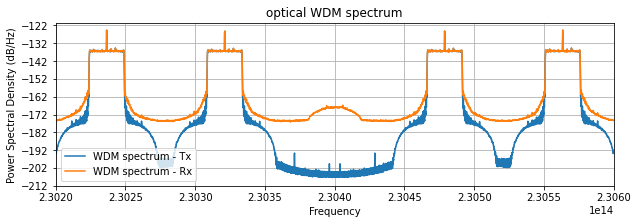

In [24]:
# plot psd
plt.figure(figsize=(10, 3))
plt.xlim(paramCh.Fc-Fs/2,paramCh.Fc+Fs/2);
plt.psd(sigWDM_Tx[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
plt.psd(sigWDM[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
plt.legend(loc='lower left')
plt.title('optical WDM spectrum');

### WDM channels coherent detection and demodulation

Demodulating channel #2 , fc: 231.2789 THz, λ: 1296.2381 nm

Local oscillator P: 10.00 dBm, lw: 200.00 kHz, FO: 0.00 MHz



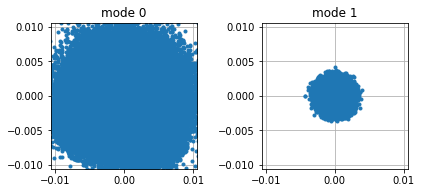

In [25]:
# Receiver

# parameters
chIndex  = 2     # index of the channel to be demodulated
plotPSD  = True

Fc = paramCh.Fc
Ts = 1/Fs
mod = QAMModem(m=paramTx.M)

freqGrid = paramTx.freqGrid
print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (Fc + freqGrid[chIndex])/1e12, const.c/(Fc + freqGrid[chIndex])/1e-9))

symbTx = symbTx_[:,:,chIndex]

# local oscillator (LO) parameters:
FO      = 0*64e6                # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated
lw      = 200e3                 # linewidth
Plo_dBm = 10                    # power in dBm
Plo     = 10**(Plo_dBm/10)*1e-3 # power in W
ϕ_lo    = 0                     # initial phase in rad    

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(Plo_dBm, lw/1e3, FO/1e6))

# generate LO field
π       = np.pi
t       = np.arange(0, len(sigWDM))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ts)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# polarization multiplexed coherent optical receiver
sigRx = pdmCoherentReceiver(sigWDM, sigLO, θsig = π/3)

# plot constellations
pconst(sigRx[0::paramTx.SpS,:], lim=True, R=3)

### Matched filtering and CD compensation

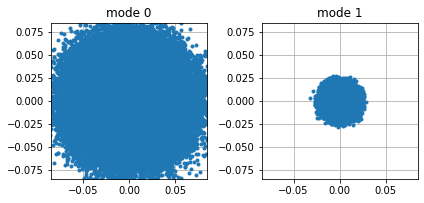

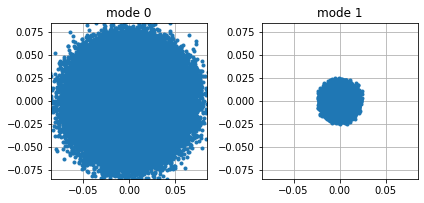

In [26]:
# Rx filtering

# Matched filtering
if paramTx.pulse == 'nrz':
    pulse = pulseShape('nrz', paramTx.SpS)
elif paramTx.pulse == 'rrc':
    pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)
    
pulse = pulse/np.max(np.abs(pulse))            
sigRx = firFilter(pulse, sigRx)

# plot constellations after matched filtering
pconst(sigRx[0::paramTx.SpS,:], lim=True, R=3)

# CD compensation
sigRx = edc(sigRx, paramCh.Ltotal, paramCh.D, Fc-Δf_lo, Fs)

# plot constellations after CD compensation
pconst(sigRx[0::paramTx.SpS,:], lim=True, R=3)

### Downsampling to 2 samples/symbol and re-synchronization with transmitted sequences

In [27]:
# decimation抽取
paramDec = parameters()
paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 2
sigRx = decimate(sigRx, paramDec)

symbRx = symbolSync(sigRx, symbTx, 2)

In [28]:
symbRx.shape

(170100, 2)

In [42]:
symbRx[0]

array([-0.31622777-0.9486833j, -0.31622777-0.9486833j])

In [ ]:
sigRx.shape

(340200, 2)

### Power normalization

In [29]:
x = sigRx
d = symbRx

x = x.reshape(len(x),2)/np.sqrt(signal_power(x))
d = d.reshape(len(d),2)/np.sqrt(signal_power(d))

### Adaptive equalization

  0%|          | 0/5 [00:00<?, ?it/s]

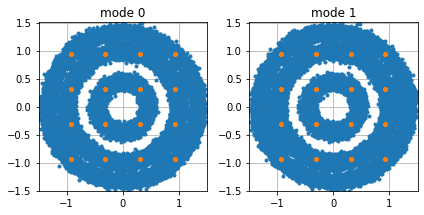

In [30]:
mod = QAMModem(m=paramTx.M)

paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS   = 2
paramEq.mu    = [5e-3, 2e-3]
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.alg   = ['da-rde','rde']
paramEq.M     = paramTx.M
#paramEq.L = [20000, 112052]
paramEq.L = [20000, 150100]
y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

#plot constellations after adaptive equalization
discard = 5000
pconst([y_EQ[discard:-discard,:], d], lim=True)

### Carrier phase recovery

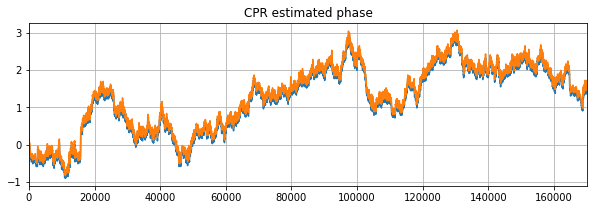

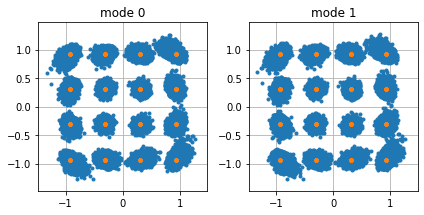

In [31]:
paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = paramTx.M
paramCPR.N   = 35
paramCPR.B   = 64
paramCPR.pilotInd = np.arange(0, len(y_EQ), 20) 

y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))

plt.figure(figsize=(10, 3))
plt.title('CPR estimated phase')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid();

discard = 5000

#plot constellations after CPR
pconst([y_CPR[discard:-discard,:], d], lim=True)

In [32]:
y_CPR[100:102,1]


array([0.90279842-0.92653318j, 0.96797015-0.87369246j])

y_CPR就是解调出来的复数坐标

### Evaluate transmission metrics

In [33]:
# correct (possible) phase ambiguity
for k in range(y_CPR.shape[1]):
    rot = np.mean(d[:,k]/y_CPR[:,k])
    y_CPR[:,k] = rot*y_CPR[:,k]

y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))


ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
GMI,_    = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')

print('     pol.X     pol.Y      ')
print('SER: %.2e, %.2e'%(SER[0], SER[1]))
print('BER: %.2e, %.2e'%(BER[0], BER[1]))
print('SNR: %.2f dB, %.2f dB'%(SNR[0], SNR[1]))
print('MI: %.2f bits, %.2f bits'%(MI[0], MI[1]))
print('GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))

     pol.X     pol.Y      
SER: 3.94e-04, 4.06e-04
BER: 9.84e-05, 1.01e-04
SNR: 21.75 dB, 21.69 dB
MI: 4.01 bits, 4.01 bits
GMI: 3.99 bits, 3.99 bits


In [34]:
y_CPR = y_CPR * np.sqrt(Es)

In [44]:
y_CPR[2,0]

(1.1939194205317474+1.5824378072384067j)

In [36]:
bits_T[0:12]

array([[0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0]], dtype=uint8)

In [37]:
np.savetxt("./received_signals_new.csv", y_CPR, delimiter=',')

In [38]:
import scipy.io as scio

In [39]:
dataNew = './received_signals_New.mat'
scio.savemat(dataNew, {'data': y_CPR})